# Visualize and annotate DESeq2 results

## Review our pipeline
In the pipeline image, the red text indicates the names of the R packages we will use to perform the analysis, the yellow boxes indicate the data (raw or processed), and the grey indicates what we will do in each step. Note that we will use [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) to identify differentially expressed genes (DEGs). This is a highly cited package that uses a negative binomial distribution to calculate DEGs. However, there are multiple pipelines and programs to do this. [Knoweng](http://education.knoweng.org/sequenceng/) has a nice interface to explore other options, including the strengths and weaknesses of each.
![](https://github.com/davidnboone/test-image/blob/master/overview-image.jpg?raw=true "pipeline overview")

## To this point we have:
1. Extracted and calculated HER2 and TNBC status of each patient.
2. Extracted count and abundance data for each transcript from those samples.
3. Prepped the transcipt count and abundance data.
4. Collapsed transcript counts to the gene level.
5. Calculated differentially expressed genes using DESeq2

## In this notebook we will:
1. Annotate the results table to include GeneSymbol and information about abundance
2. Visualize the results with a few QC plots
3. Generate a heatmap of filtered DEGs

___
___
___

## We still need the proper R packages loaded. We will need to start by reloading them with the same code.
Of course you can use the typical library() command to load each as well.




In [5]:
#you can very easily use "install.packages" or "biocLite" to install the packages and "library" to load them
#however, instead I am installing a package called pacman that will determine if a package is already installed
#if it is not it will install it and after will load it
#this method is convenient when sharing code that requires the use of others packages

if (!require("pacman")) install.packages("pacman")
pacman::p_load(R.utils, data.table, tximport, DESeq2, biomaRt, jsonlite, BiocParallel, ggplot2, gplots, RColorBrewer, devtools, pheatmap)


Loading required package: pacman


## Set the working directory to the workspace set up in the previous notebook.
 You can check to deterimine if you are in the correct directory by examining your working directory. If it is not the proper workspace then change to proper directory.


In [1]:
getwd()

[1] "/Users/dnb14/Documents/jupyter/tcga_brca_rnaseq"

In [6]:
#only need to run if you are not in the proper working directory.
base_dir <- "/Volumes/Oesterreich"
setwd(base_dir)

project_name <- "TCGA_Her2_TNBC_DEGs"
date <- "2019_02_06" #use the same date as notebook 1,2, and 3
setwd(project_name)

outdir <- "DESeq_output" #to save all of the images and final tables


## Load the necessary files.
If you compiled all the Notebooks into one and did not restart the kernel since completing DeSEQ, you can skip this step.

For visualization and annotation we will need the following:
1. dds ("her2.tnbc.results.Rda")
2. results files (dataframe - "her2.tnbc.results.csv" and results Rda "her2.tnbc.results.Rda"))
3. gene level TPM abundance file ("brca.untran.gene.tpm.Rda")
4. final TNBC and HER2 IDs


You can load/read these using the code below. **Be sure the commands point to the appropriate directories that contain the data**


In [7]:
#read in dds file after running DESeq. Because it was saved as an Rda we can use the 
#load() function and it will retain the appropriate variable name
load(file = file.path(date, "her2.tnbc.results.Rda"))

#read in the ordered results csv to the same variable name as when it was created.
#note we specify that the first column is the names of the rows and not a data column
results.ordered <- read.csv(file = file.path(date, outdir, "her2.tnbc.results.csv"), row.names = 1)

#load results file as Rda (before made a dataframe, which is used for visualization)
load(file = file.path(date, outdir, "her2.tnbc.results.Rda"))

#read in the abundance data to append to results file
load(file = file.path(date, "brca.untran.gene.tpm.Rda"))

#load final HER2 and TNBC IDs
load(file = file.path(date, "her2.ids.final.Rda"))
load(file = file.path(date, "tnbc.ids.final.Rda"))



___
___
___

# 1. Finalize results output table
We need to add information to the DESeq output to help visualize, explore, and export the data. In this section we will:
- a. Shrink the log fold change using a statistical function built into DESeq2.
- b. Add Gene Symbol and Biotype to the results.
- c. Add information about abundance to the results.

## 1a. Log fold change shrinkage for visualization and ranking
Before exploratory visualization of the results, it is proper to use a statistical analysis to shrink the log fold change (LFC) to account for expression. As specified in the [manual](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#the-deseqdataset), "shrinkage of effect size (LFC estimates) is useful for visualization and ranking of genes. To shrink the LFC, we pass the dds object to the function lfcShrink. Below we specify to use the apeglm method for effect size shrinkage (Zhu, Ibrahim, and Love 2018), which improves on the previous estimator." This is particularly useful to eliminate artifically inflated fold change values from genes expressed at a low level. For example, a gene may have only 1 count in HER2 but 100 in TNBC. The fold change would be 100 for this gene, but given that even 100 counts is low, this gene may be below the limits of detection and hence the differences are by chance only. 

In [8]:
#LFC for shrinkage and visualization 
#this line will tell us the name of the coeficients we can shrink
resultsNames(dds)


[1] "Intercept"               "BC_subtype_TNBC_vs_HER2"

In [9]:
#LFC for shrinkage and visualization
#shrink based on the TNBC vs HER2  coeficient
#we found the name of the coeficient in the previous output
#type is the statistical test to use. There are multiple ones you can select.
results_LFC <- lfcShrink(dds, coef="BC_subtype_TNBC_vs_HER2", type="apeglm")
results_LFC.df <- as.data.frame(results_LFC)

#save after running to save computational time later
save(results_LFC.df, file = file.path(date, outdir, "results_LFC.Rda"))

#write to table so it can be easily read outside of R
write.csv(results_LFC.df, file = file.path(date, outdir, "results_LFC.df.csv"))

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    bioRxiv. https://doi.org/10.1101/303255


Let's see what the differences look like of the most significant genes

In [11]:
results_LFC_ordered <- results_LFC.df[order(results_LFC.df$pvalue, na.last = TRUE),]

message("LFC results")
head(results_LFC_ordered)

message("raw fold change")
head(results.ordered)

LFC results


,baseMean,log2FoldChange,lfcSE,pvalue,padj
ENSG00000141736,111881.653,-3.896150,0.1499402,3.331450e-150,4.932878e-146
ENSG00000161395,10474.829,-3.274083,0.1398366,1.681954e-122,1.245234e-118
ENSG00000171428,4752.450,-4.538358,0.2040792,6.170364e-111,3.045486e-107
ENSG00000105388,4442.615,-4.065222,0.2501551,1.188649e-104,4.400083e-101
ENSG00000108932,1935.616,-3.595371,0.1669125,3.593392e-104,1.064147e-100
ENSG00000172057,18939.110,-2.933157,0.1391933,1.501635e-99,3.705785e-96


raw fold change


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000141736,111881.653,-3.907757,0.1497027,-26.10345,3.331450e-150,4.932878e-146
ENSG00000161395,10474.829,-3.289347,0.1397486,-23.53760,1.681954e-122,1.245234e-118
ENSG00000171428,4752.450,-4.556832,0.2036122,-22.37996,6.170364e-111,3.045486e-107
ENSG00000105388,4442.615,-5.409955,0.2490188,-21.72509,1.188649e-104,4.400083e-101
ENSG00000108932,1935.616,-3.610246,0.1665687,-21.67421,3.593392e-104,1.064147e-100
ENSG00000172057,18939.110,-2.936965,0.1386755,-21.17869,1.501635e-99,3.705785e-96


## 1b. Use of BiomaRt to convert Ensembl gene Ids to Gene symbol
We can use the bioconducter package [biomaRt](https://bioconductor.org/packages/release/bioc/html/biomaRt.html) to convert Ensembl IDs to Gene Symbol, which is the typical format for readable gene names. I highly recommend reading the manual as this package can do many things not discussed in this exercise. 



In [12]:
########################################################################################
######################## make gene names readable (gene symbol) ########################
####################### done through the use of the biomaRt package ####################
########################################################################################


#set ensembl as dataset from ensembl v81 (gencode v23). same as we used above in Tximport
#dataset referst to species
#biomart is the specific annotation
#version is the version

ensembl <- useDataset(dataset = "hsapiens_gene_ensembl", mart = useEnsembl(biomart = 'ENSEMBL_MART_ENSEMBL', version = 81))

#create list of gene ids to convert
geneidlist <- rownames(results_LFC.df)

#create data frame with gene id, gene name, gene source, and gene biotype
#attributes are what we are searching for. here we want the external gene name and i included gene biotype because it might be interesting to look at coding vs noncoding genes
#filters are what we use as input for the query
#values are what we want to translate
#mart defines what species and verion to use.
ensembl.translate <- getBM(attributes = c("ensembl_gene_id", "external_gene_name", "gene_biotype"), filters = "ensembl_gene_id", values = geneidlist, mart = ensembl)
row.names(ensembl.translate) <- ensembl.translate$ensembl_gene_id

#examine ensembl.translate
head(ensembl.translate)





,ensembl_gene_id,external_gene_name,gene_biotype
ENSG00000000003,ENSG00000000003,TSPAN6,protein_coding
ENSG00000000419,ENSG00000000419,DPM1,protein_coding
ENSG00000000457,ENSG00000000457,SCYL3,protein_coding
ENSG00000000460,ENSG00000000460,C1orf112,protein_coding
ENSG00000000938,ENSG00000000938,FGR,protein_coding
ENSG00000000971,ENSG00000000971,CFH,protein_coding


Now we need to merge this data with our results file and export the intermediate table as a .csv to be easily shared with others.

In [13]:
#merge results w/ ensembl.translate
#note row names of results.fdr.threshold are Ensembl geneids
results.merged <- merge(results_LFC.df, ensembl.translate, by.x = "row.names", by.y = "ensembl_gene_id", all.x = TRUE)


#set row.names column as actual row names
row.names(results.merged) <- results.merged$Row.names

#remove 1st column b/c repetitive
results.merged <- results.merged[, -1]

#order by padj value
results.merged.padj <- results.merged[order(results.merged$padj), ]

#see the differences between the unmerged and merged data tables
#biomart translate table
message("Ensembl Translate")
head(ensembl.translate)

#raw output table
message("Unmerged output")
head(results_LFC.df)

#merged final table
message("Final merged table")
head(results.merged.padj)

#save final merged table
write.csv(results.merged.padj, file = file.path(date, outdir, "gene_symbol_lfc_results.csv"))



Ensembl Translate


,ensembl_gene_id,external_gene_name,gene_biotype
ENSG00000000003,ENSG00000000003,TSPAN6,protein_coding
ENSG00000000419,ENSG00000000419,DPM1,protein_coding
ENSG00000000457,ENSG00000000457,SCYL3,protein_coding
ENSG00000000460,ENSG00000000460,C1orf112,protein_coding
ENSG00000000938,ENSG00000000938,FGR,protein_coding
ENSG00000000971,ENSG00000000971,CFH,protein_coding


Unmerged output


,baseMean,log2FoldChange,lfcSE,pvalue,padj
ENSG00000000003,3299.5339,0.48492515,0.09421783,1.263068e-07,4.067474e-07
ENSG00000000419,2628.8405,0.05875981,0.06255112,3.458272e-01,4.057256e-01
ENSG00000000457,2089.2488,-0.40759732,0.06256123,3.743003e-11,1.788404e-10
ENSG00000000460,1343.9175,0.58237054,0.07561676,4.552599e-15,3.304428e-14
ENSG00000000938,613.4288,0.44195074,0.10486142,1.298513e-05,3.239610e-05
ENSG00000000971,3512.5000,-0.28252209,0.10096758,4.007700e-03,6.937340e-03


Final merged table


,baseMean,log2FoldChange,lfcSE,pvalue,padj,external_gene_name,gene_biotype
ENSG00000141736,111881.653,-3.896150,0.1499402,3.331450e-150,4.932878e-146,ERBB2,protein_coding
ENSG00000161395,10474.829,-3.274083,0.1398366,1.681954e-122,1.245234e-118,PGAP3,protein_coding
ENSG00000171428,4752.450,-4.538358,0.2040792,6.170364e-111,3.045486e-107,NAT1,protein_coding
ENSG00000105388,4442.615,-4.065222,0.2501551,1.188649e-104,4.400083e-101,CEACAM5,protein_coding
ENSG00000108932,1935.616,-3.595371,0.1669125,3.593392e-104,1.064147e-100,SLC16A6,protein_coding
ENSG00000172057,18939.110,-2.933157,0.1391933,1.501635e-99,3.705785e-96,ORMDL3,protein_coding


## 1c. Add abundance information to results file.
In our example we arbitrarily filtered out most genes expressed at low levels before we calculated the differentially expressed genes. If you remember, we did this just to decrease the computational time and power needed to perform the analysis. Typically this would not be done. Instead, we often need to include some information about expression in the results table to allow filtering based on expression. A typical cutoff is requiring 10% of samples to be greater than 1 TPM (something that is fairly easy to confirm in the lab). But, an investigator could be more stringent and require the median or a minimum of 1 TPM. Accordingly, we will add the 90th percentile and median of both HER2 and TNBC samples to the data table. 


In [14]:
#This block of code uses the gene-level tpm data (brca.untran.gene.tpm) 
#and the final her2 (her2.ids.final) and tnbc (tnbc.ids.final)ids
#that were calculated in Notebook 3. They were reloaded at the beginning of this notebook
#in case you started fresh

#subset tpm data to just genes in the results file and just the her2 or tnbc samples
her2.tpm.df <- brca.untran.gene.tpm[rownames(results.merged.padj), her2.ids.final]
tnbc.tpm.df <- brca.untran.gene.tpm[rownames(results.merged.padj), tnbc.ids.final]

#confirm that her2.tpm.df and tnbc.tpm.df has the same rows in same order as results.merged.padj
message("her2.tpm.df data")
nrow(her2.tpm.df)
head(her2.tpm.df)

message("tnbc.tpm.df data")
nrow(tnbc.tpm.df)
head(tnbc.tpm.df)

message("results.merged.padj data")
nrow(results.merged.padj)
head(results.merged.padj)




her2.tpm.df data


[1] 14807

,TCGA.3C.AALI.01,TCGA.3C.AALK.01,TCGA.A1.A0SM.01,TCGA.A1.A0SN.01,TCGA.A2.A04W.01,TCGA.A2.A04X.01,TCGA.A2.A0CX.01,TCGA.A2.A0D1.01,TCGA.A2.A0EY.01,TCGA.A2.A0SY.01,⋯,TCGA.LL.A7T0.01,TCGA.LL.A9Q3.01,TCGA.OL.A5RY.01,TCGA.OL.A5RZ.01,TCGA.OL.A5S0.01,TCGA.PE.A5DC.01,TCGA.PE.A5DD.01,TCGA.S3.AA14.01,TCGA.UL.AAZ6.01,TCGA.UU.A93S.01
ENSG00000141736,3006.70411,493.697142,2770.36666,2765.53743,1071.019634,767.935920,1385.698844,969.5283886,1634.209229,336.5109216,⋯,190.079357,142.292383,1479.4528153,2475.8607491,74.5136089,105.041935,64.1180327,1136.827901,1717.485242,4121.861149
ENSG00000161395,302.88792,131.725353,226.07234,388.85656,189.557733,155.429845,195.643490,217.0159684,626.440308,68.2103151,⋯,53.405961,31.972915,447.7180427,512.8637313,46.4496795,33.536307,34.2483369,174.295883,578.488501,610.296887
ENSG00000171428,28.74895,55.302066,56.20971,230.27816,5.800916,2.597870,90.013568,0.4067453,69.255691,237.5117311,⋯,3.017830,49.669484,4.8073676,14.8411022,1.2650455,142.052794,367.1364467,46.748110,3.045550,2.380961
ENSG00000105388,1826.80489,1.370403,458.25978,120.72268,81.478678,364.259140,1.647483,1.6776914,1.328891,0.4569937,⋯,1.737568,5.238484,0.3087550,0.4919454,0.3143005,0.718368,0.6910529,0.935445,4.029284,1.760716
ENSG00000108932,54.52252,22.958019,259.31451,62.27786,5.378119,7.272364,1.284667,1.0932248,11.167812,11.6573046,⋯,2.775772,9.556515,0.6679126,2.9868575,0.6116100,2.051345,3.4510832,11.704753,23.177525,3.641839
ENSG00000172057,879.81012,191.764325,877.74838,1236.88798,953.924882,422.564120,1483.702784,405.4003897,97.281234,79.4481337,⋯,124.495917,140.738210,85.4606496,1374.2025597,39.2382840,71.676209,73.6991279,225.451234,2381.442894,2766.688603


tnbc.tpm.df data


[1] 14807

,TCGA.A1.A0SK.01,TCGA.A1.A0SO.01,TCGA.A1.A0SP.01,TCGA.A2.A04P.01,TCGA.A2.A04Q.01,TCGA.A2.A04T.01,TCGA.A2.A0CM.01,TCGA.A2.A0D0.01,TCGA.A2.A0D2.01,TCGA.A2.A0ST.01,⋯,TCGA.LL.A740.01,TCGA.OL.A5D6.01,TCGA.OL.A5D7.01,TCGA.OL.A5RW.01,TCGA.OL.A66I.01,TCGA.OL.A66P.01,TCGA.OL.A6VO.01,TCGA.OL.A97C.01,TCGA.S3.AA10.01,TCGA.S3.AA15.01
ENSG00000141736,6.1697163,189.370430,41.8129504,21.0998117,32.6875564,69.1101390,41.519291,29.1733140,53.6518865,46.0465349,⋯,229.1724920,196.175860,25.9925947,47.6180826,53.3550347,89.3989767,76.294836,85.512752,54.5343192,13.1813091
ENSG00000161395,13.4120469,15.153017,12.6560669,9.7962739,10.0428564,19.0029054,12.182766,9.9774649,11.2989544,11.9051193,⋯,33.2693005,26.365532,12.7778196,31.8664106,14.6689793,44.6441453,24.545214,35.367780,14.5001986,6.4109681
ENSG00000171428,0.3166713,4.017678,1.1827850,1.3961618,1.3564500,1.1648751,2.726078,1.6184601,0.9638411,7.0996168,⋯,6.7427684,4.472079,1.2066411,1.3312827,2.0229585,0.9153888,2.400927,3.824558,1.5559889,1.4880868
ENSG00000105388,0.6186390,1.209497,0.1983118,0.3724015,0.2279968,0.2534404,5.578268,0.7343484,0.4842162,0.2151192,⋯,0.2905101,1.628524,0.4795970,0.4771382,0.2852008,0.4236491,0.303054,2.157323,0.3211489,0.1075701
ENSG00000108932,1.4873190,2.978907,0.8875011,0.6794867,1.2054417,0.9530300,1.858836,0.3767727,0.9246579,1.5587368,⋯,0.7636760,4.698457,0.6910421,0.6591199,1.3130895,0.8487178,1.188291,7.835188,1.5943680,1.1009183
ENSG00000172057,28.4930388,70.759929,25.6055792,69.7479686,39.1269272,44.7747398,27.999071,24.1745374,28.0017541,47.8858003,⋯,93.5158929,37.917091,30.3299971,41.0466602,36.1397213,63.0530302,56.302322,58.346277,35.7746396,24.5954083


results.merged.padj data


[1] 14807

,baseMean,log2FoldChange,lfcSE,pvalue,padj,external_gene_name,gene_biotype
ENSG00000141736,111881.653,-3.896150,0.1499402,3.331450e-150,4.932878e-146,ERBB2,protein_coding
ENSG00000161395,10474.829,-3.274083,0.1398366,1.681954e-122,1.245234e-118,PGAP3,protein_coding
ENSG00000171428,4752.450,-4.538358,0.2040792,6.170364e-111,3.045486e-107,NAT1,protein_coding
ENSG00000105388,4442.615,-4.065222,0.2501551,1.188649e-104,4.400083e-101,CEACAM5,protein_coding
ENSG00000108932,1935.616,-3.595371,0.1669125,3.593392e-104,1.064147e-100,SLC16A6,protein_coding
ENSG00000172057,18939.110,-2.933157,0.1391933,1.501635e-99,3.705785e-96,ORMDL3,protein_coding


Because the rows of each are exactly the same we can easily calculate the median and 90th percentile in the HER2 and TNBC specific data frames and add as a column to our results file using the apply function.

In [15]:
#use the apply function to calculate the median and make a new column in the deseq results file
results.merged.padj$median_her2 <- apply(her2.tpm.df, 1, median)
results.merged.padj$median_tnbc <- apply(tnbc.tpm.df, 1, median)

#calculate 90th percentile using quantile function
results.merged.padj$ninetieth_percentile_her2 <- apply(her2.tpm.df, 1, function(x) quantile(x, 0.9))
results.merged.padj$ninetieth_percentile_tnbc <- apply(tnbc.tpm.df, 1, function(x) quantile(x, 0.9))

                                                   
#examine the results
head(results.merged.padj)
                                                   
#save the final datatable for export
write.csv(results.merged.padj, file = file.path(date, outdir, "FINAL_annotated_TNBC_HER2_DEG_table.csv"))
                                                   

,baseMean,log2FoldChange,lfcSE,pvalue,padj,external_gene_name,gene_biotype,median_her2,median_tnbc,ninetieth_percentile_her2,ninetieth_percentile_tnbc
ENSG00000141736,111881.653,-3.896150,0.1499402,3.331450e-150,4.932878e-146,ERBB2,protein_coding,525.536425,56.9624032,2718.80460,106.328557
ENSG00000161395,10474.829,-3.274083,0.1398366,1.681954e-122,1.245234e-118,PGAP3,protein_coding,73.268158,12.3682454,427.31812,26.388068
ENSG00000171428,4752.450,-4.538358,0.2040792,6.170364e-111,3.045486e-107,NAT1,protein_coding,33.624558,2.6764650,341.82883,7.931381
ENSG00000105388,4442.615,-4.065222,0.2501551,1.188649e-104,4.400083e-101,CEACAM5,protein_coding,4.800327,0.3841519,134.12064,2.509175
ENSG00000108932,1935.616,-3.595371,0.1669125,3.593392e-104,1.064147e-100,SLC16A6,protein_coding,7.497587,1.1478959,46.83393,3.104168
ENSG00000172057,18939.110,-2.933157,0.1391933,1.501635e-99,3.705785e-96,ORMDL3,protein_coding,136.466837,41.0466602,852.99870,70.548107


___
___
___

# 2. Visualize the results with a few quality control plots

## 2a. If you know anything about the dataseq, a quick first step to check the analysis is to confirm what you know.
In this exercise, we know that HER2+ samples should have higher HER2+ (aka ERBB2) expression than TNBC samples. You can find the ensembl ID for HER2 in many different databases including [genecards.org](https://www.genecards.org/cgi-bin/carddisp.pl?gene=ERBB2&keywords=erbb2) to subset the results file based on row, or subset based on the gene symbol name that we added above. The column name is "external_gene_name."

In [16]:
#sanity check to make sure that ERBB2 (HER2) is differentially expressed
results.merged.padj[results.merged.padj$external_gene_name == "ERBB2", ]


,baseMean,log2FoldChange,lfcSE,pvalue,padj,external_gene_name,gene_biotype,median_her2,median_tnbc,ninetieth_percentile_her2,ninetieth_percentile_tnbc
ENSG00000141736,111881.7,-3.89615,0.1499402,3.33145e-150,4.932878e-146,ERBB2,protein_coding,525.5364,56.9624,2718.805,106.3286


### Visualize HER2 results.
From the above output you can see that HER2 is very significantly different between the two groups with an FDR (p-adj) of e-146. You can also see that the tpm data makes sense as the median of her2 is nearly 10 fold higher than the  median of tnbc. You can visualize this result as well. You could make a dotplot with ggplot using the tpm data, but to demonstrate some of the quick built in functions of DESeq2, we will make a dotplot using the built-in plotCounts function with the dds (immediate output of DESeq) as the input. This creats a dotplot of the count data. This is handy if you want to visualize before you add the abundance data.

null device 
          1

null device 
          1

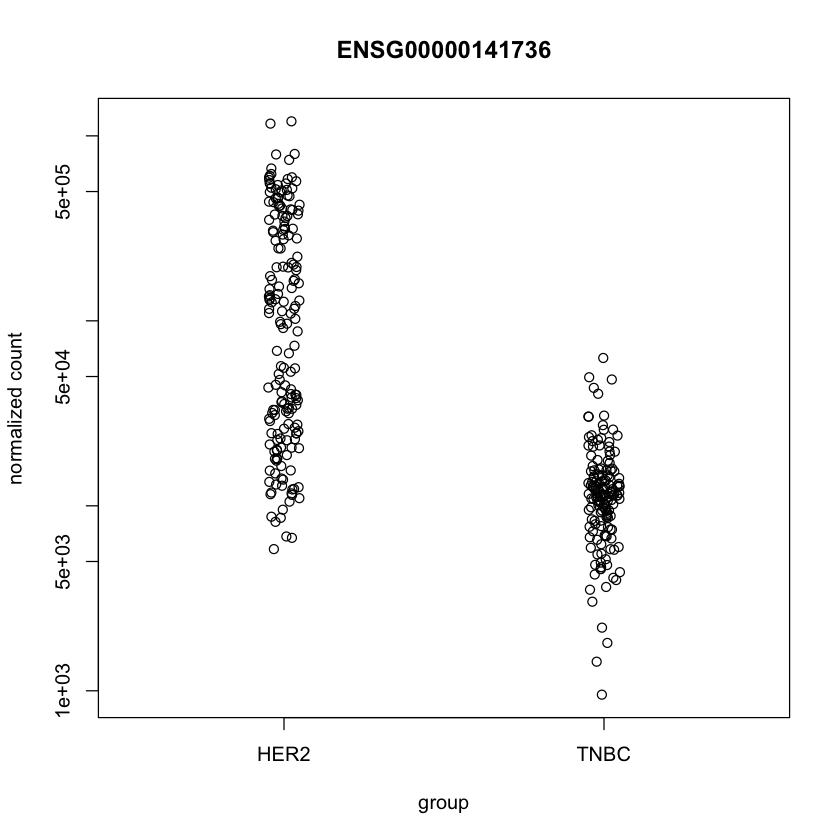

In [17]:
#Make a dotplot of HER2 expression

#print to screen
plotCounts(dds, gene="ENSG00000141736", intgroup = "BC_subtype")
dev.off()

#save graph as tiff to file
tiff(file.path(date, outdir, "HER2_counts_graph.tiff"))
plotCounts(dds, gene="ENSG00000141736", intgroup = "BC_subtype")
dev.off()


The dotplot confirms the analysis for HER2 (ERBB2), but other plots are more useful to visualize all the genes at once.

## 2b. Generate MA Plots
MA plots are a great first visualization of the results because they show on a single graph all genes, their raw expression, LFC, and significance (colored based on a threshold). These are the three features that are typically used when filtering DEGs for downstream analysis. **note** the plotMA function works with the raw output of the results() function in DESeq2 and not on the data tables that were created for export. Hence the use of results_LFC below instead of results.merged.padj. Again this is convenient if you want to visualize QC plots before taking the time to fully annotate the results datatable.

pdf 
  2

corrected LFCs


null device 
          1

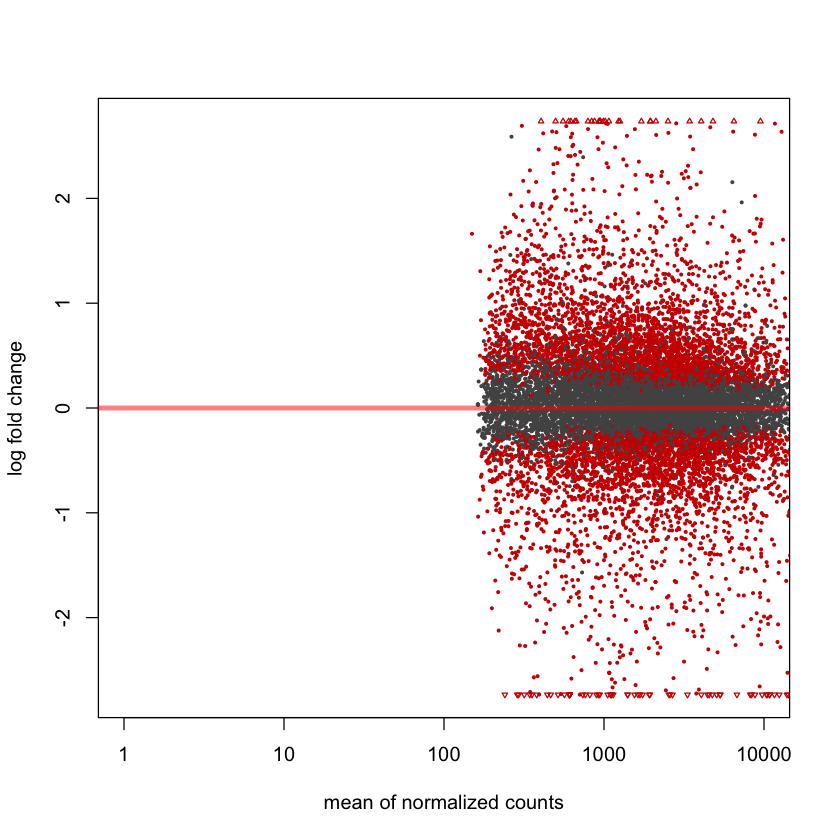

In [18]:
#note this function only works on the output of the results() function in DESeq2 and not on
#the dataframe created of the results

#MA Plot of corrected LFCs
#save to file
tiff(file.path(date, outdir, "MAplot_correctedLFC.tiff"))
plotMA(results_LFC, alpha = 0.001, xlim = c(1, 10000)) #we have an idea of a limit based on the summary performed in Notebook 3
dev.off()

#print to screen
message("corrected LFCs")
plotMA(results_LFC, alpha = 0.001, xlim=c(1,10000)) #we have an idea of a limit based on the summary performed in Notebook 3
dev.off()


### Can you tell me why there are no genes with counts under 200?

## 2c. Generate Volcano plot
A volcano plot is another nice general visualization of your overall results. This graph plots the -log10 padj value as they y-axis and adjusted LFC as the x-axis.
**note** this is not a built in function of DESeq2, hence we are using the final results data table to generate the volcano plot

pdf 
  2

null device 
          1

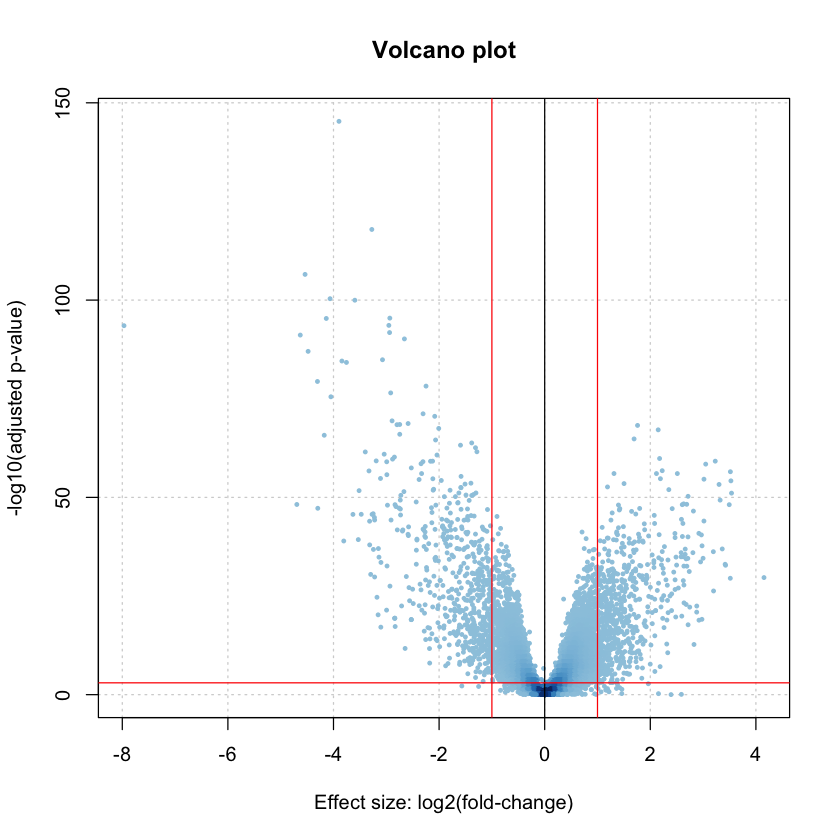

In [19]:
#volcano plot
#graphics.off()
alpha <- 0.001 # Threshold on the adjusted p-value
cols <- densCols(results.merged.padj$log2FoldChange, -log10(results.merged.padj$padj))

tiff(file.path(date, outdir, "volcano.tiff"), res = 100)
plot(results.merged.padj$log2FoldChange, -log10(results.merged.padj$padj), col=cols, panel.first=grid(),
     main="Volcano plot", xlab="Effect size: log2(fold-change)", ylab="-log10(adjusted p-value)",
     pch=20, cex=0.6)
abline(v=0)
abline(v=c(-1,1), col="red")
abline(h=-log10(alpha), col="red")
dev.off()

plot(results.merged.padj$log2FoldChange, -log10(results.merged.padj$padj), col=cols, panel.first=grid(),
     main="Volcano plot", xlab="Effect size: log2(fold-change)", ylab="-log10(adjusted p-value)",
     pch=20, cex=0.6)
abline(v=0)
abline(v=c(-1,1), col="red") #this makes a vertical line equivalent to a fold change of 2, you can change this if you'd like
abline(h=-log10(alpha), col="red") #this makes a horizontal line equivalent to the alpha that we set (p-adj <= 0.001)
dev.off()

This helps to show that there are roughly an equivalent number of genes that are upregulated and downregulated in the two groups, but there is one gene that is dramatically downregulated (~256 fold). The redlines also set markers to visualize the number of genes that might be considered as differentially expressed. Here we set a fold change of 2 and an adj pvalue of 0.001. All of the genes represented in the upper right and upper left rectangles are the differentially expressed genes at these conditions. This graph also shows that there are quite a few genes with very low padj values with small fold changes. In fact, it seems that most genes have a padj of below 0.001. You could make a histogram of padj values to make an informed decision of setting a threshold. 

This volcano plaot can also be altered to change the color of the significant genes, or even add the names of the genes if you'd like. Let's add gene symbol of highly significant genes to the volcano plot.

### Now add gene names of highly significant genes to the volcano plot.
We will use a log2 fold change of 2 and padj <1e-50 as filters to not overcrowd the plot with gene names.

pdf 
  2

null device 
          1

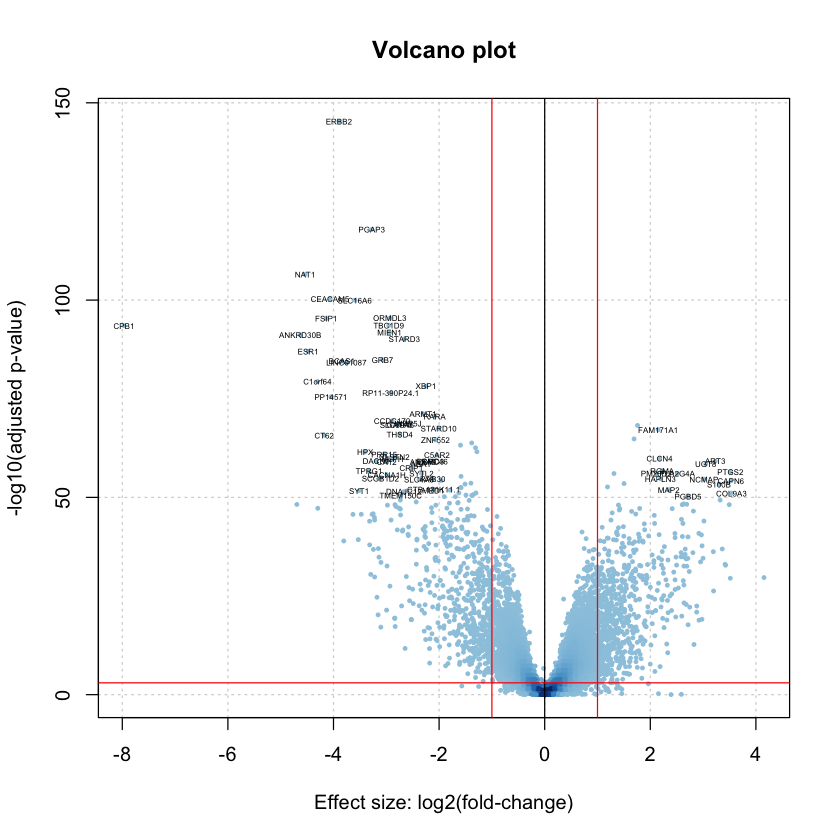

In [20]:
#select genes with absolute value of LFC >=2 and padj <= 1e-50
#this will be used to add the names of just these genes
gn.selected <- abs(results.merged.padj$log2FoldChange) >= 2 & results.merged.padj$padj <= 1e-50 

#same code as above to generate volcano plot
alpha <- 0.001 # Threshold on the adjusted p-value
cols <- densCols(results.merged.padj$log2FoldChange, -log10(results.merged.padj$padj))

tiff(file.path(date, outdir, "volcano_with_names.tiff"), res = 100)
plot(results.merged.padj$log2FoldChange, -log10(results.merged.padj$padj), col=cols, panel.first=grid(),
     main="Volcano plot", xlab="Effect size: log2(fold-change)", ylab="-log10(adjusted p-value)",
     pch=20, cex=0.6)
abline(v=0)
abline(v=c(-1,1), col="red")
abline(h=-log10(alpha), col="red")

#add names to volcano plot
text(results.merged.padj$log2FoldChange[gn.selected],
     -log10(results.merged.padj$padj)[gn.selected],
     lab=results.merged.padj$external_gene_name[gn.selected], cex=0.4)

dev.off()

plot(results.merged.padj$log2FoldChange, -log10(results.merged.padj$padj), col=cols, panel.first=grid(),
     main="Volcano plot", xlab="Effect size: log2(fold-change)", ylab="-log10(adjusted p-value)",
     pch=20, cex=0.6)
abline(v=0)
abline(v=c(-1,1), col="red") #this makes a vertical line equivalent to a fold change of 2, you can change this if you'd like
abline(h=-log10(alpha), col="red") #this makes a horizontal line equivalent to the alpha that we set (p-adj <= 0.001)
#dev.off()

#add names to volcano plot
text(results.merged.padj$log2FoldChange[gn.selected],
     -log10(results.merged.padj$padj)[gn.selected],
     lab=results.merged.padj$external_gene_name[gn.selected], cex=0.4)

dev.off()

**note** Now we can easily see that ERBB2 has the smallest padj and CPB1 is the gene that has the largest fold change.

## 2d. Visualizing sample to sample variability from counts data

### Transformation of raw counts for visualization
To calculate differential expressed genes, it is critical to use raw count data. However, for downstream analysis and visualization it is often advantageous to transform the data. We could use our log2 TPM data to generate the PCA plot, but instead I would like to introduce you to built in DESeq2 functions to create an accurate PCA plot from counts. 

There are a couple of methods that we can use to normalize counts to do this. Variance stabilizing transformations (VST) (Tibshirani 1988; Huber et al. 2003; Anders and Huber 2010) produce transformed data on the log2 scale which has been normalized with respect to library size and thus has a slight advantage. The point of VST is to remove the dependence of the variance on the mean, particularly the high variance of the logarithm of count data when the mean is low. 

DESeq2 contains a VST function. We will perform a blinded VST on the dds to generate QC plots that test sample variance.


In [21]:
#transform count data (variance stabilizing transformation) to aid in visualization
vsd <- vst(dds)

#make vsd into a dataframe and save
vsd.df <- as.data.frame(assay(vsd))
write.csv(vsd.df, file = file.path(date, outdir, "vst.txt"))

### Create PCA plot with VST values
PCA plots show the samples in the 2D plane spanned by their first two principal components. This type of plot is useful for visualizing the overall effect of experimental covariates and batch effects (text from DESeq manual).

pdf 
  2

null device 
          1

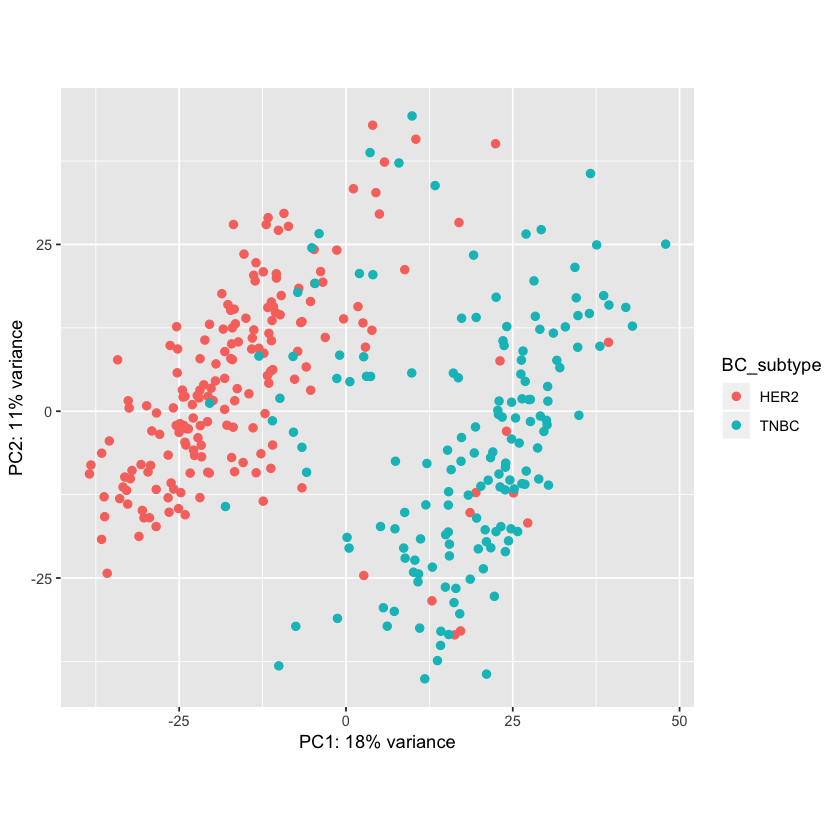

In [22]:
#create PCA plot with variance stabilizing transformation values 
#this code saves the image to file
tiff(file.path(date, outdir, "PCA_vst.tiff"))
pcaData <- plotPCA(vsd, returnData = TRUE, intgroup="BC_subtype")
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color=BC_subtype)) +
  geom_point(size=2) +
  # geom_text(aes(label=name),hjust=0.3, vjust=0.1) + #use this line if you want to display sample names over points
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()
dev.off()

#this code block prints the PCA block to screen
ggplot(pcaData, aes(PC1, PC2, color=BC_subtype)) +
  geom_point(size=2) +
  # geom_text(aes(label=name),hjust=0.3, vjust=0.1) + #use this line if you want to display sample names over points
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()
dev.off()



**note** For the most part there is a clear separation between HER2+ and TNBC samples. This demonstrates that the subtypes are very different, in fact they almost look like completely different diseases. However, there are a few HER2 samples that look similar to TNBC and a few TNBC that look like HER2. This could indicate that the clinical data was wrong or the diagnosis was wrong. Perhaps RNAseq values from 1000s of genes is more sensitive for diagnosis than a single FISH or IHC result of HER2. However, this result could be biological. There could be some HER2 samples that behave as TNBC. If this is the case, the patients with those tumors might not respond to targeted HER2 therapy. Likewise, perhaps some TNBC tumors behave like HER2 samples.

# 3. Generate Heatmaps using top differentially expressed genes
Finally, to bring everything together, we will generate heatmaps with the top differentially expressed genes with different filtering levels based on expression, fold change, and significance. 
There are multiple tools to generate heat maps. In this tutorial we will use [heatmap.3] (https://www.rdocumentation.org/packages/GMD/versions/0.3.3/topics/heatmap.3), which is a varient of gplots heatmap.2. I suggest reading the manual to understand all options. We will create the heatmap from  the more traditional abundance (TPM) data that we already downloaded and processed but a heatmap could be made from the vst data as well. 

First install heatmap.3.

In [23]:
#install heatmap.3 from source
#the output will give you an SHA-1 hash of the file
source_url("https://raw.githubusercontent.com/obigriffith/biostar-tutorials/master/Heatmaps/heatmap.3.R")

SHA-1 hash of file is 015fc0457e61e3e93a903e69a24d96d2dac7b9fb


## Filter significant DEGs
Through DESeq, we identified the differentially expressed genes. However, it is customary to narrow this list by applying a few filters based on:
1) Expression
2) Fold Change
3) Significance

We first will filter by expression because genes expressed at low levels are the noisiest in RNAseq and the most difficult to validate through wet-lab experiments. In my hands, genes with a TPM of 1 are readily validated. Typically, I use 0.5-1TPM as my cutoff, and typically will filter if expressed below that in >90% of samples. While the cutoffs will largely depend on your choices and dataset, for this exercise, we will filter genes that are expressed less than TPM of 1 at the 90th percentile in either TNBC or HER2 positive. 

Fold change filters are typically set at 1.5 or 2.0

Significane thresholds are typically at least <0.01 padj...but in a large dataset like this, smaller thresholds are common.

In [24]:
#Filter by expression. To do this we will use the tpm values that we downloaded and collapsed to gene level earlier

#filter based on minimum 90th percentile expression of tpm of 1 in HER2 or TNBC samples
exp.cutoff <- 1
results.sig.exp <- results.merged.padj[results.merged.padj$ninetieth_percentile_her2 >= exp.cutoff | results.merged.padj$ninetieth_percentile_tnbc >= exp.cutoff, ]

#filter based on FC of greater than 1.5 or less than -1.5
fc.cutoff <- 1.5
results.sig.exp.fc <- results.sig.exp[(2^results.sig.exp$log2FoldChange >= fc.cutoff) | (2^results.sig.exp$log2FoldChange <= 1/fc.cutoff), ]

#filter with a padj of 0.001
padj.cutoff <- 0.001
results.sig.exp.fc.padj <- results.sig.exp.fc[results.sig.exp.fc$padj <= padj.cutoff, ]

#Determine the number of significant genes that pass the filters
numSigGenes <- nrow(results.sig.exp.fc.padj)
message("Number of significant genes")
numSigGenes

#Number of significantly upregulated genes
message("Number of significantly upregulated genes")
nrow(results.sig.exp.fc.padj[(2^results.sig.exp$log2FoldChange >= fc.cutoff), ])


#Number of significantly downregulated genes
message("Number of significantly downregulated genes")
nrow(results.sig.exp.fc.padj[(2^results.sig.exp$log2FoldChange <= 1/fc.cutoff), ])

#determine the names of the genes
filtered.genes <- row.names(results.sig.exp.fc.padj)

#save the table of significant genes that can then be imported into a pathway analysis software or explored in greater depth 
write.csv(results.sig.exp.fc.padj, file = file.path(date, outdir, "her2vstnbc_0.001p_fc1.5_exp90_1.csv"))




Number of significant genes


[1] 3199

Number of significantly upregulated genes


[1] 1821

Number of significantly downregulated genes


[1] 1472

Note that the number of significant genes is less than the original summary of the output at the end of Notebook 3. That summary stated 3996 genes were significantly upregulated and 3375 genes were signfinicantly downregulated. At the end of this notebook, you will adjust the filtering levels to create a 'stringent' table of DE genes.

## Create the heatmap
See comments for rationale behind the code

In [25]:
#To visualize our DESeq and filtering results, we need to create a matrix (not a dataframe) 
#of abundance (tpm) of all samples (HER2+/TNBC her2.ids.final and tnbc.ids.final) 
#and all genes that are significantly different and pass filtering criteria (filtered.genes)
#remember her2.tpm.df is unlogged tpm data we generated above from all her2 samples
#the same is true of tnbc.tpm.df

hm.her2.tpm.filtered <- her2.tpm.df[filtered.genes, ]
hm.tnbc.tpm.filtered <- tnbc.tpm.df[filtered.genes, ]
hm.tpm.filtered.combined <- cbind(hm.her2.tpm.filtered, hm.tnbc.tpm.filtered)

#for visualization purposes, tpm data is often better log2 transformed
#note we need to add a small value to each tpm so that we do not try to log 0
hm.log.tpm <- log2(hm.tpm.filtered.combined + 0.001)

#likewise median centering the rows allows for easier visualization and interpration

#rowMedians calculates the median of each row. we then subtract the median from every value
row.medians <- rowMedians(as.matrix(hm.log.tpm))
hm.log.median.centered.tpm <- hm.log.tpm - row.medians

#check all of the transformations
message("untransformed")
head(hm.tpm.filtered.combined)

message("log2 transformed")
head(hm.log.tpm)

message("median centered rows")
head(hm.log.median.centered.tpm)
row.medians[1:6]


untransformed


,TCGA.3C.AALI.01,TCGA.3C.AALK.01,TCGA.A1.A0SM.01,TCGA.A1.A0SN.01,TCGA.A2.A04W.01,TCGA.A2.A04X.01,TCGA.A2.A0CX.01,TCGA.A2.A0D1.01,TCGA.A2.A0EY.01,TCGA.A2.A0SY.01,⋯,TCGA.LL.A740.01,TCGA.OL.A5D6.01,TCGA.OL.A5D7.01,TCGA.OL.A5RW.01,TCGA.OL.A66I.01,TCGA.OL.A66P.01,TCGA.OL.A6VO.01,TCGA.OL.A97C.01,TCGA.S3.AA10.01,TCGA.S3.AA15.01
ENSG00000141736,3006.70411,493.697142,2770.36666,2765.53743,1071.019634,767.935920,1385.698844,969.5283886,1634.209229,336.5109216,⋯,229.1724920,196.175860,25.9925947,47.6180826,53.3550347,89.3989767,76.294836,85.512752,54.5343192,13.1813091
ENSG00000161395,302.88792,131.725353,226.07234,388.85656,189.557733,155.429845,195.643490,217.0159684,626.440308,68.2103151,⋯,33.2693005,26.365532,12.7778196,31.8664106,14.6689793,44.6441453,24.545214,35.367780,14.5001986,6.4109681
ENSG00000171428,28.74895,55.302066,56.20971,230.27816,5.800916,2.597870,90.013568,0.4067453,69.255691,237.5117311,⋯,6.7427684,4.472079,1.2066411,1.3312827,2.0229585,0.9153888,2.400927,3.824558,1.5559889,1.4880868
ENSG00000105388,1826.80489,1.370403,458.25978,120.72268,81.478678,364.259140,1.647483,1.6776914,1.328891,0.4569937,⋯,0.2905101,1.628524,0.4795970,0.4771382,0.2852008,0.4236491,0.303054,2.157323,0.3211489,0.1075701
ENSG00000108932,54.52252,22.958019,259.31451,62.27786,5.378119,7.272364,1.284667,1.0932248,11.167812,11.6573046,⋯,0.7636760,4.698457,0.6910421,0.6591199,1.3130895,0.8487178,1.188291,7.835188,1.5943680,1.1009183
ENSG00000172057,879.81012,191.764325,877.74838,1236.88798,953.924882,422.564120,1483.702784,405.4003897,97.281234,79.4481337,⋯,93.5158929,37.917091,30.3299971,41.0466602,36.1397213,63.0530302,56.302322,58.346277,35.7746396,24.5954083


log2 transformed


,TCGA.3C.AALI.01,TCGA.3C.AALK.01,TCGA.A1.A0SM.01,TCGA.A1.A0SN.01,TCGA.A2.A04W.01,TCGA.A2.A04X.01,TCGA.A2.A0CX.01,TCGA.A2.A0D1.01,TCGA.A2.A0EY.01,TCGA.A2.A0SY.01,⋯,TCGA.LL.A740.01,TCGA.OL.A5D6.01,TCGA.OL.A5D7.01,TCGA.OL.A5RW.01,TCGA.OL.A66I.01,TCGA.OL.A66P.01,TCGA.OL.A6VO.01,TCGA.OL.A97C.01,TCGA.S3.AA10.01,TCGA.S3.AA15.01
ENSG00000141736,11.553968,8.9474854,11.435862,11.433345,10.064771,9.584844,10.4363991,9.9211408,10.6743779,8.394514,⋯,7.8402964,7.6160111,4.7000843,5.5734679,5.7375795,6.4822025,6.2535324,6.418085,5.7691190,3.7205312
ENSG00000161395,8.242645,7.0414002,7.820647,8.603098,7.566501,7.280129,7.6120907,7.7616640,9.2910355,6.091939,⋯,5.0561630,4.7206359,3.6756827,4.9940099,3.8747949,5.4804314,4.6174286,5.144405,3.8581002,2.6807672
ENSG00000171428,4.845487,5.7892875,5.812773,7.847240,2.536530,1.377885,6.4920866,-1.2942597,6.1138816,7.891861,⋯,2.7535550,2.1612682,0.2721918,0.4139003,1.0171797,-0.1259683,1.2641920,1.935670,0.6387586,0.5744279
ENSG00000105388,10.835108,0.4556523,8.840025,6.915565,6.348368,8.508825,0.7211386,0.7473370,0.4113082,-1.126600,⋯,-1.7783820,0.7044509,-1.0571003,-1.0645003,-1.8049005,-1.2356570,-1.7176005,1.109910,-1.6342005,-3.2033014
ENSG00000108932,5.768807,4.5209891,8.018565,5.960671,2.427370,2.862623,0.3625171,0.1299091,3.4814038,3.543286,⋯,-0.3870796,2.2324940,-0.5310684,-0.5992001,0.3940636,-0.2349444,0.2501022,2.970152,0.6738893,0.1400173
ENSG00000172057,9.781050,7.5831981,9.777665,10.272500,9.897733,8.723030,10.5349874,8.6632072,6.6041045,6.311960,⋯,6.5471551,5.2448144,4.9227210,5.3592281,5.1755534,5.9785167,5.8151481,5.866593,5.1609057,4.6203758


median centered rows


,TCGA.3C.AALI.01,TCGA.3C.AALK.01,TCGA.A1.A0SM.01,TCGA.A1.A0SN.01,TCGA.A2.A04W.01,TCGA.A2.A04X.01,TCGA.A2.A0CX.01,TCGA.A2.A0D1.01,TCGA.A2.A0EY.01,TCGA.A2.A0SY.01,⋯,TCGA.LL.A740.01,TCGA.OL.A5D6.01,TCGA.OL.A5D7.01,TCGA.OL.A5RW.01,TCGA.OL.A66I.01,TCGA.OL.A66P.01,TCGA.OL.A6VO.01,TCGA.OL.A97C.01,TCGA.S3.AA10.01,TCGA.S3.AA15.01
ENSG00000141736,4.904026,2.297544,4.785920,4.783403,3.414829,2.934903,3.7864577,3.2711994,4.024436,1.7445724,⋯,1.1903550,0.96606968,-1.9498571,-1.0764735,-0.9123618,-0.16773884,-0.39640896,-0.23185684,-0.8808224,-2.929410
ENSG00000161395,3.611639,2.410394,3.189641,3.972092,2.935495,2.649123,2.9810847,3.1306580,4.660030,1.4609332,⋯,0.4251570,0.08962993,-0.9553233,0.3630039,-0.7562111,0.84942540,-0.01357739,0.51339856,-0.7729058,-1.950239
ENSG00000171428,2.413569,3.357369,3.380855,5.415322,0.104611,-1.054034,4.0601681,-3.7261783,3.681963,5.4599425,⋯,0.3216365,-0.27065036,-2.1597267,-2.0180183,-1.4147388,-2.55788679,-1.16772650,-0.49624830,-1.7931599,-1.857491
ENSG00000105388,10.549946,0.170491,8.554864,6.630404,6.063207,8.223664,0.4359773,0.4621757,0.126147,-1.4117616,⋯,-2.0635433,0.41928959,-1.3422616,-1.3496616,-2.0900618,-1.52081828,-2.00276180,0.82474918,-1.9193618,-3.488463
ENSG00000108932,4.349727,3.101910,6.599485,4.541591,1.008290,1.443543,-1.0565625,-1.2891704,2.062324,2.1242065,⋯,-1.8061591,0.81341438,-1.9501480,-2.0182797,-1.0250160,-1.65402395,-1.16897736,1.55107239,-0.7451903,-1.279062
ENSG00000172057,3.832310,1.634458,3.828925,4.323760,3.948993,2.774289,4.5862469,2.7144668,0.655364,0.3632191,⋯,0.5984146,-0.70392601,-1.0260194,-0.5895124,-0.7731871,0.02977623,-0.13359231,-0.08214701,-0.7878348,-1.328365


[1] 6.6499414 4.6310060 2.4319185 0.2851613 1.4190796 5.9487404

null device 
          1

null device 
          1

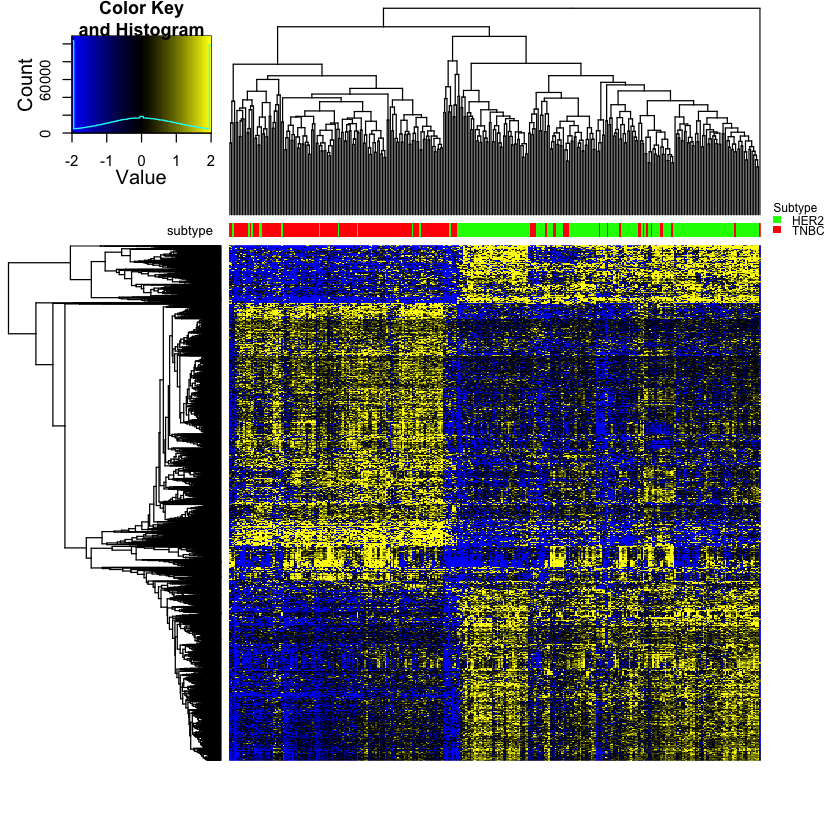

In [26]:
#we need to establish colors for her2 and tnbc to label the columns (samples) as we have 
#too many samples to read the names
#in this command we establish that green represents her2 and red tnbc
#we also establish how many her2 and tnbc samples there are using the rep (repeat) command
colcolors <- cbind(subtype = c(rep("green", ncol(hm.her2.tpm.filtered)), rep("red", ncol(hm.tnbc.tpm.filtered))))

#next we need to establish what the colors in the heatmap represent and how many colors to use
#breaks establishes how many colors. in this case we go from -2 to 2 by 0.05.
#-2 and 2 were selected as they will show all samples greater than 4 fold from the median as dark colors
#samples closer to the median will have a duller color
#these numbers can be altered for best visualization purposes
breaks <- seq(-2, 2, by = 0.05)

#this command establishes what colors to use. In this example values around the median will be black
#higher than the median yellow, and lower than the median will be blue.
#the colorpanel command helps break all of the colors into different gradients based on the number of breaks
#note that you can change the colors
#also note that there are only so many different versions of each color
col<- colorpanel(n = length(breaks) - 1, low = "blue", mid = "black", high = "yellow")


#heatmap of filtered genes clustering both by gene and sample
#tpm data has to be a matrix
#ColSideColors establishes color for each column as defined in colcolors
#breaks and col are described and defined above
#note that because we have so many genes and samples the labels cannot be read, so we removed them with the labRow, LabCol options.
#dendogram tells heatmap to do clustering on rows, columns, both, or neither
#density info places a histogram in the legend to see the frequency of genes at each level
heatmap.3(as.matrix(hm.log.median.centered.tpm), ColSideColors = colcolors, breaks = breaks, col = col, dendrogram = "both", density.info = "histogram", labRow = FALSE, labCol = FALSE)
legend(x=0.96, y=0.84, xpd = TRUE, title = "Subtype", legend=c("HER2","TNBC"), fill=c("green","red"), border=FALSE, bty="n", cex=0.6, y.intersp = 0.7, inset = 0.1)
dev.off()


#code below is the same but saves the heatmap to file
tiff(file.path(date, outdir, "DEGs_heatmap_0.001padj_1.5FC_1tpm_90thpercentile.tiff"))
heatmap.3(as.matrix(hm.log.median.centered.tpm), ColSideColors = colcolors, breaks = breaks, col = col, dendrogram = "both", density.info = "histogram", labRow = FALSE, labCol = FALSE)
legend(x=0.96, y=0.84, xpd = TRUE, title = "Subtype", legend=c("HER2","TNBC"), fill=c("green","red"), border=FALSE, bty="n", cex=0.6, y.intersp = 0.7, inset = 0.1)
dev.off()



The heatmap demonstrates that with the filtered list of differentially expressed genes, the samples largely cluster based on breast cancer subtype. However, there are still a few outliers. This is a similar result to the PCA plot of the counts data. The heatmap also demonstrates that there is roughly the same number of up and down-regulated genes in the filtered set.

## What can we do with the results?
The answer to this goes beyond the goals of this notebook. However, it is quite common to see if the DEGs are enriched in any biological or clinically actionable pathways. This can be done through Gene Set Enrichment Analysis (GSEA) or with other pathway analysis tools such as Ingenuity Pathway Analysis. Another option is to use the DEGs as features in a causal discovery or some other machine learning problem. An example of a nice causal discovery tool is [Tetrad](http://www.phil.cmu.edu/tetrad/) developed out of Pitt and CMU in the Center for Causal Discovery. There is even another github exercise at the DBMI that is in development on how to perform caucal analysis with Tetrad.

___
___
___

## In the code box below change the expression, fold change, and padj cutoffs to determine which cutoff used above is the most stringent

1. What are the number of significant genes if fold change cutoff is 2.0, but other paramaters above are the same?
2. What are the number of significant genes if padj.cutoff is set to 0.00000000001, but other paramaters above are the same?
3. What are the number of significant genes if exp.cutoff is 1 for a MINIMUM instead of median in either TNBC or HER2? *note min is a function in R.

create a final dataframe named results.stringent with all 3 of these thresholds.

## Now you make a heatmap of results.stringent
compare and contrast the two heatmaps.